# FINAL DECISIONS 

### thresholds obtained from varying different thresholds on training set

- RF = 0.38
- XGB = 0.42
- SVC = 0.36
- VTG = 0.40
- LR_stacked = 0.44
- KNN_stacked = 0.44
- GBM_stacked = 0.40
- NB_stacked = 0.16

### finally picked images & models

- picked images & model
  - 47 -> Bayes stacked
  - 95 -> SVC
  - 96 -> Bayes stacked
  - 138 -> RF
  - 166 -> KNN stacked
  - 191 -> KNN stacked
  - 203 -> SVC
  - 253 -> XGB
  - 287 -> SVC

- edge cases -> keep as backup
  - 8
  - 20
  - 193
  - 233

----

# load libraries & data

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.

from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

### Prepare the Features and Dataframe for the Evaluation

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)


# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(
    columns=[col for col in df.columns if "_obj" in col]
)  # drop 'object' columns

# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

 -> dataframe has 7217 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns
train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


----

# load models

### Here we load in our Pickle Files (found in Folder "models") these contain our best Models for each Algorithm

In [3]:
with open(os.path.join("../models/FINAL/RF_calib.pickle"), "rb") as f:  # Random Forrest Calibrated
    rf = pickle.load(f)

with open(os.path.join("../models/FINAL/XGB_calib.pickle"), "rb") as f: # XGB Calibrated
    xgb = pickle.load(f)

with open(os.path.join("../models/FINAL/SVC_calib.pickle"), "rb") as f: # SVC Calibrated
    svc = pickle.load(f)

with open(os.path.join("../models/FINAL/VTG_calib.pickle"), "rb") as f: # Voting Calibrated
    vtg = pickle.load(f)

with open(os.path.join("../models/FINAL/stacking_logreg_calib.pickle"), "rb") as f: # Stacking Logistic Regression Calibrated
    sLR = pickle.load(f)

with open(os.path.join("../models/FINAL/stacking_knn_calib.pickle"), "rb") as f: # Stacking KNN Calibrated
    sKNN = pickle.load(f)

with open(os.path.join("../models/FINAL/stacking_gbm_calib.pickle"), "rb") as f: # Stacking Gradient Boosting Machine Calibrated
    sGBM = pickle.load(f)

with open(os.path.join("../models/FINAL/stacking_bayes_calib.pickle"), "rb") as f: # Stacking Naive Bayes Calibrated
    sNB = pickle.load(f)

## prepare level0-estimates for stacking models
here we let our Base Model Predict the Classification values 0 or 1, and the Probabilities for each class (predict_proba)

In [4]:
# 2. Generate predictions using the base models
svc_pred_train = svc.predict(X_train)
xgb_pred_train = xgb.predict(X_train)
rf_pred_train = rf.predict(X_train)

# 2. Generate predictions using the base models
svc_proba_train = svc.predict_proba(X_train)
xgb_proba_train = xgb.predict_proba(X_train)
rf_proba_train = rf.predict_proba(X_train)

# 2. Generate predictions using the base models
svc_pred_test = svc.predict(X_test)
xgb_pred_test = xgb.predict(X_test)
rf_pred_test = rf.predict(X_test)

# 2. Generate predictions using the base models
svc_proba_test = svc.predict_proba(X_test)
xgb_proba_test = xgb.predict_proba(X_test)
rf_proba_test = rf.predict_proba(X_test)

# Generate New Dataframe out of the Base Model Predictions as Features for the Stacking Models
X_train_stacked = np.column_stack((svc_pred_train, xgb_pred_train, rf_pred_train))
X_test_stacked = np.column_stack((svc_pred_test, xgb_pred_test, rf_pred_test))

# Do the same for the Probabilities
X_train_stacked_proba = np.column_stack(
    (svc_proba_train, xgb_proba_train, rf_proba_train)
)
X_test_stacked_proba = np.column_stack((svc_proba_test, xgb_proba_test, rf_proba_test))

----

# evaluation on images


In [5]:
proba_rf = rf.predict_proba(X_test)
proba_xgb = xgb.predict_proba(X_test)
proba_svc = svc.predict_proba(X_test)
proba_vtg = vtg.predict_proba(X_test)
proba_LR = sLR.predict_proba(X_test_stacked_proba)
proba_KNN = sKNN.predict_proba(X_test_stacked_proba)
proba_GBM = sGBM.predict_proba(X_test_stacked_proba)
proba_NB = sNB.predict_proba(X_test_stacked_proba)

# Implementing the Thresholds for Class 1 Predictions per Model (why this thresholds were choosen u find in another Notebook)
pred_rf = (proba_rf[:, 1] > 0.38) * 1
pred_xgb = (proba_xgb[:, 1] > 0.42) * 1
pred_svc = (proba_svc[:, 1] > 0.36) * 1
pred_vtg = (proba_vtg[:, 1] > 0.40) * 1
pred_LR = (proba_LR[:, 1] > 0.44) * 1
pred_KNN = (proba_KNN[:, 1] > 0.44) * 1
pred_GBM = (proba_GBM[:, 1] > 0.40) * 1
pred_NB = (proba_NB[:, 1] > 0.16) * 1

# Dictionary which holds the Prediction Data for each Model (later used in Custom Function)
inp = {
    "RF": [pred_rf, proba_rf],
    "XGB": [pred_xgb, proba_xgb],
    "SVC": [pred_svc, proba_svc],
    "VTG": [pred_vtg, proba_vtg],
    "LR_s": [pred_LR, proba_LR],
    "KNN_s": [pred_KNN, proba_KNN],
    "GBM_s": [pred_GBM, proba_GBM],
    "NB_s": [pred_NB, proba_NB],
}



# Error Analysis Part Starts here!

30it [00:05,  5.32it/s]


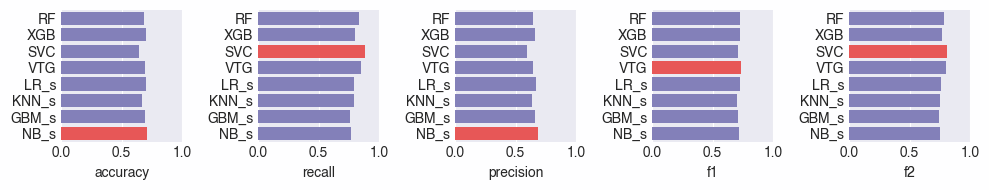

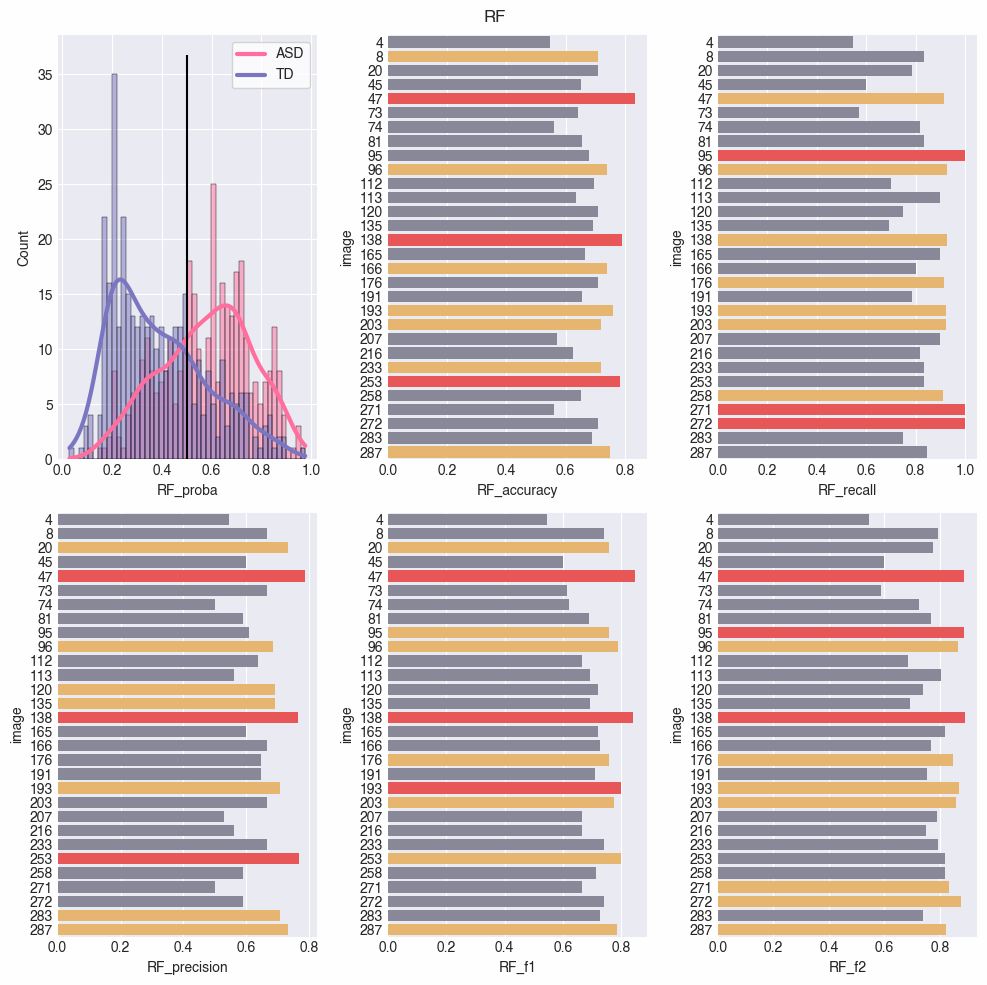

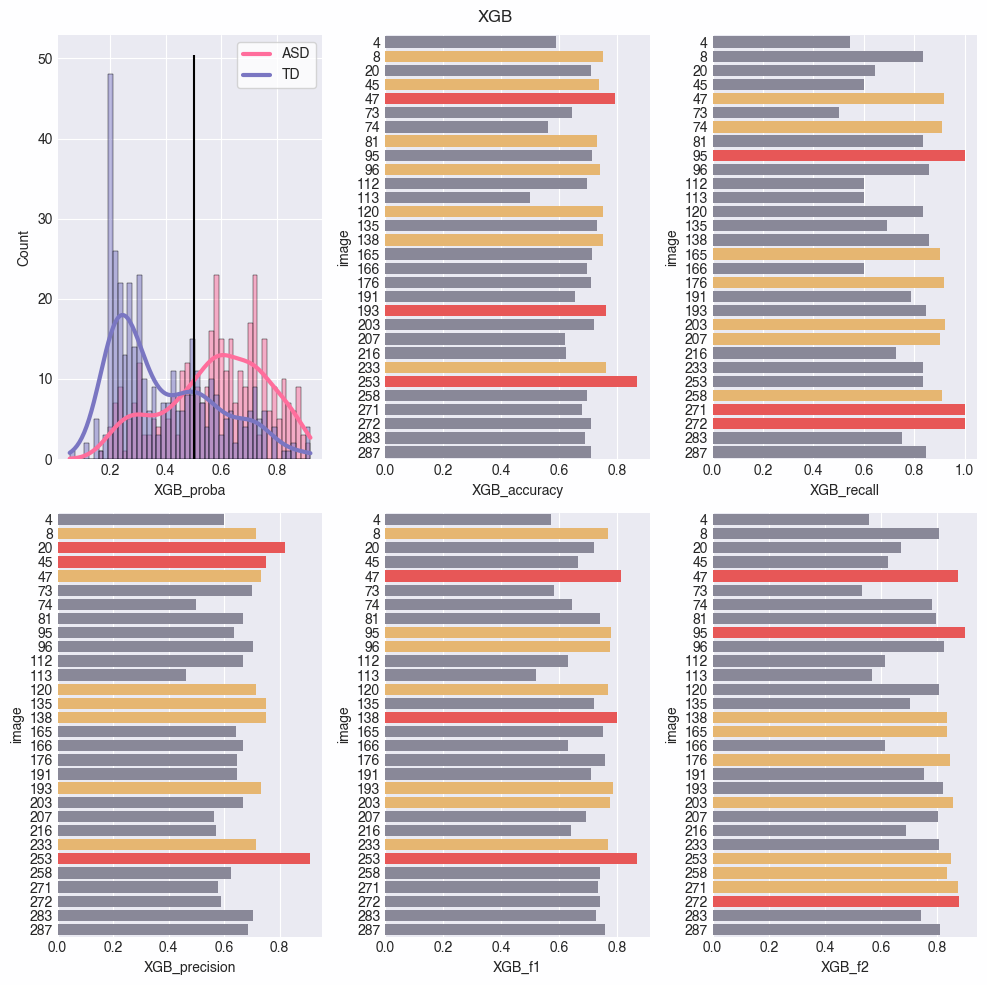

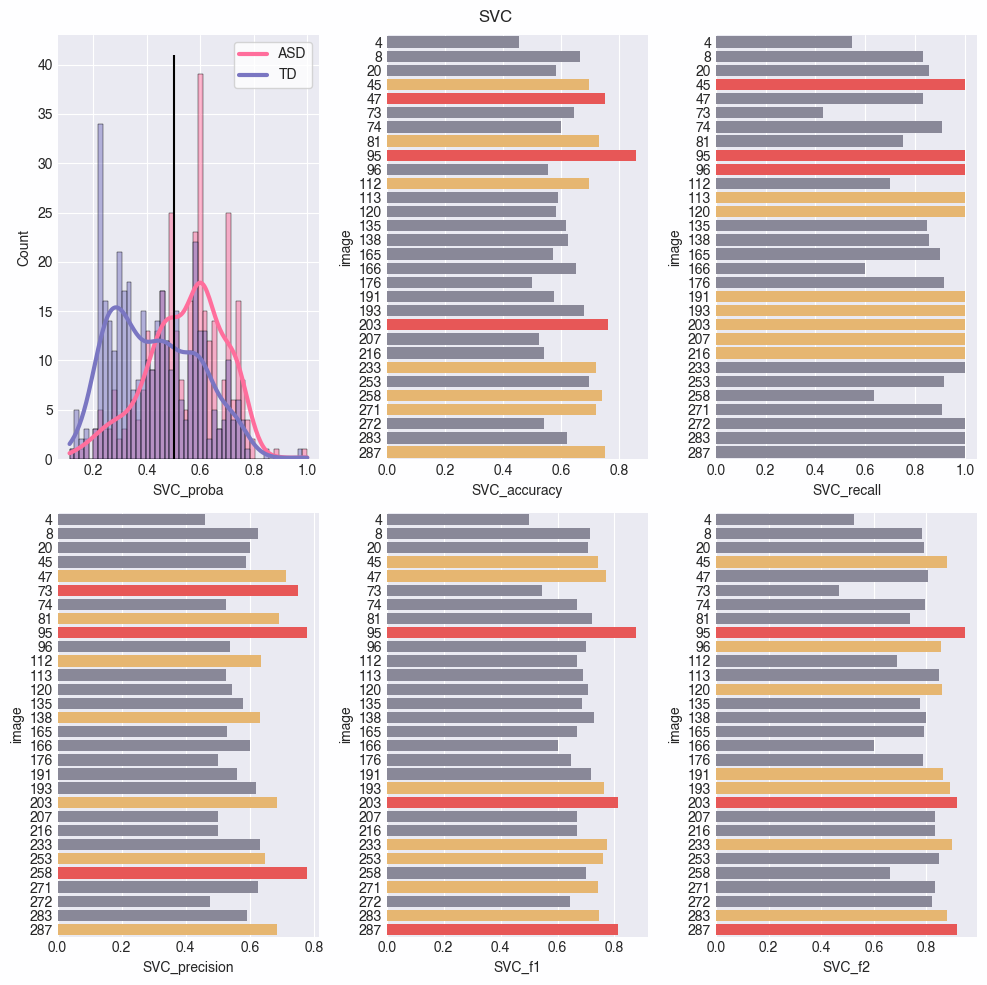

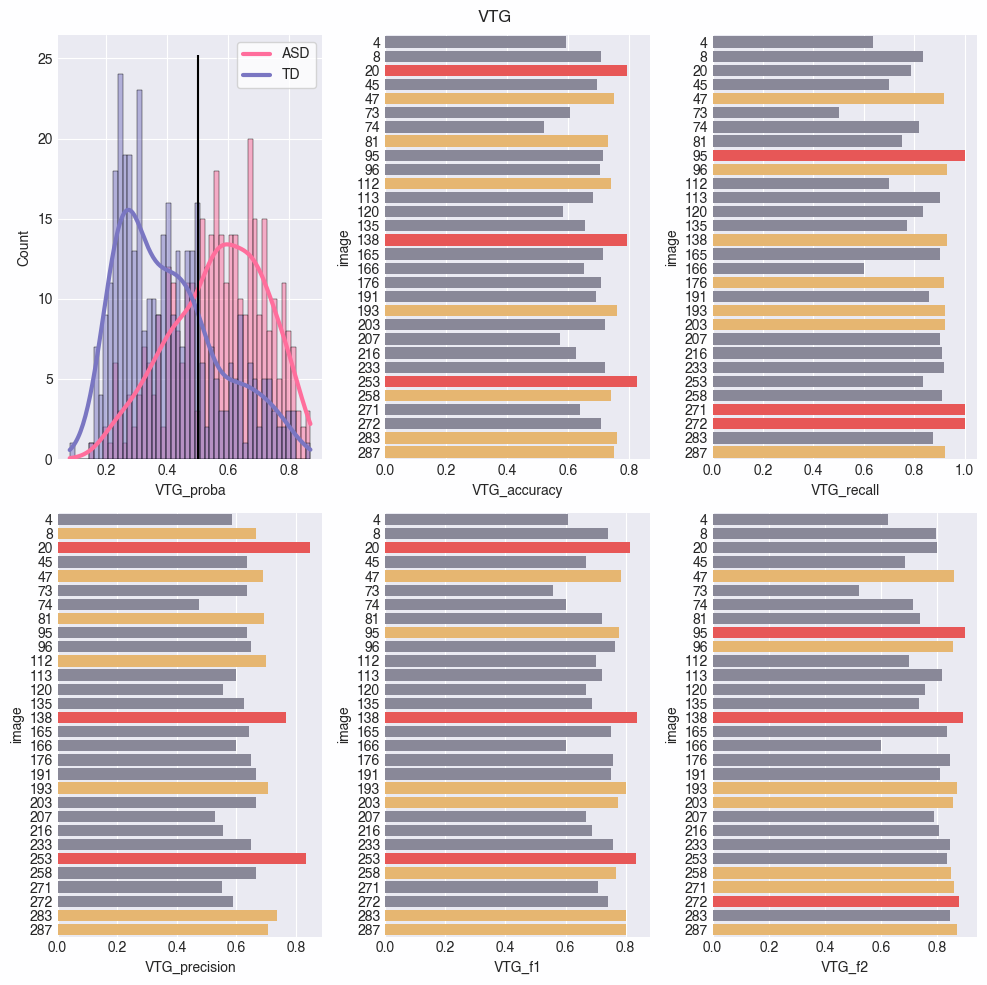

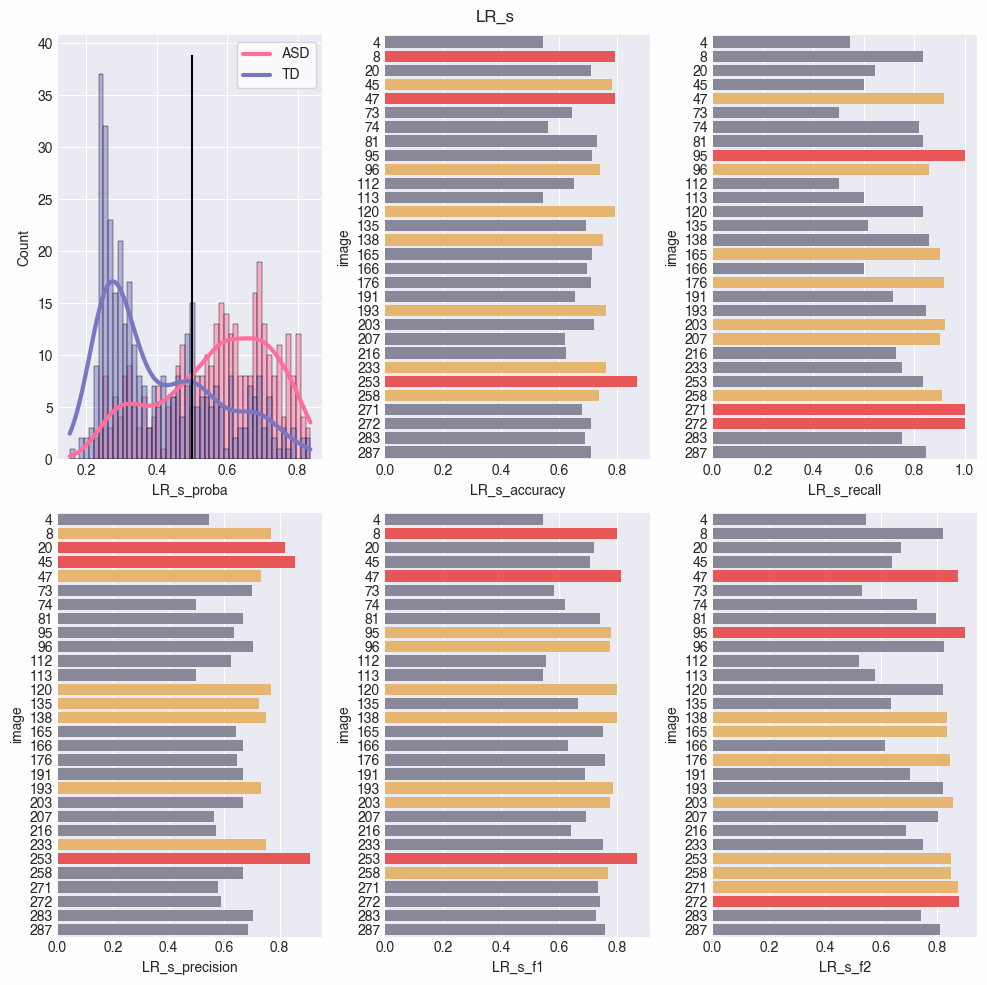

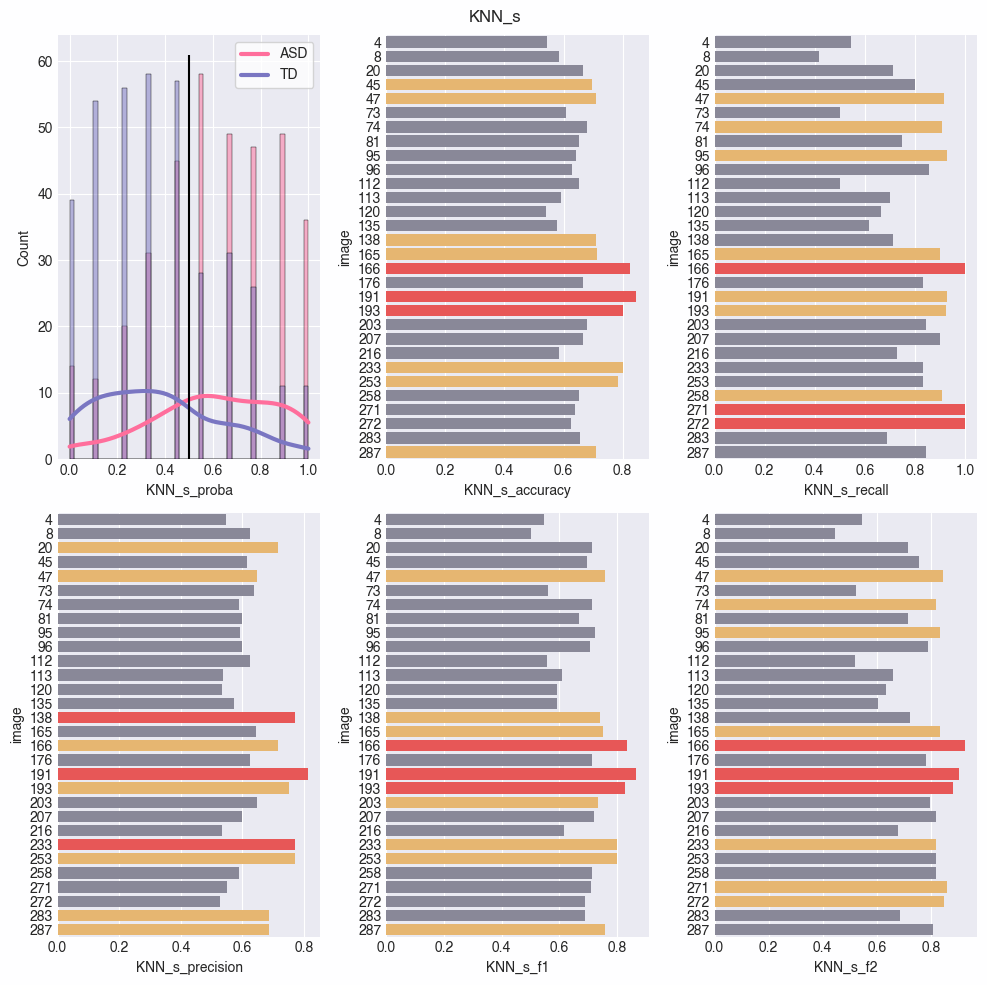

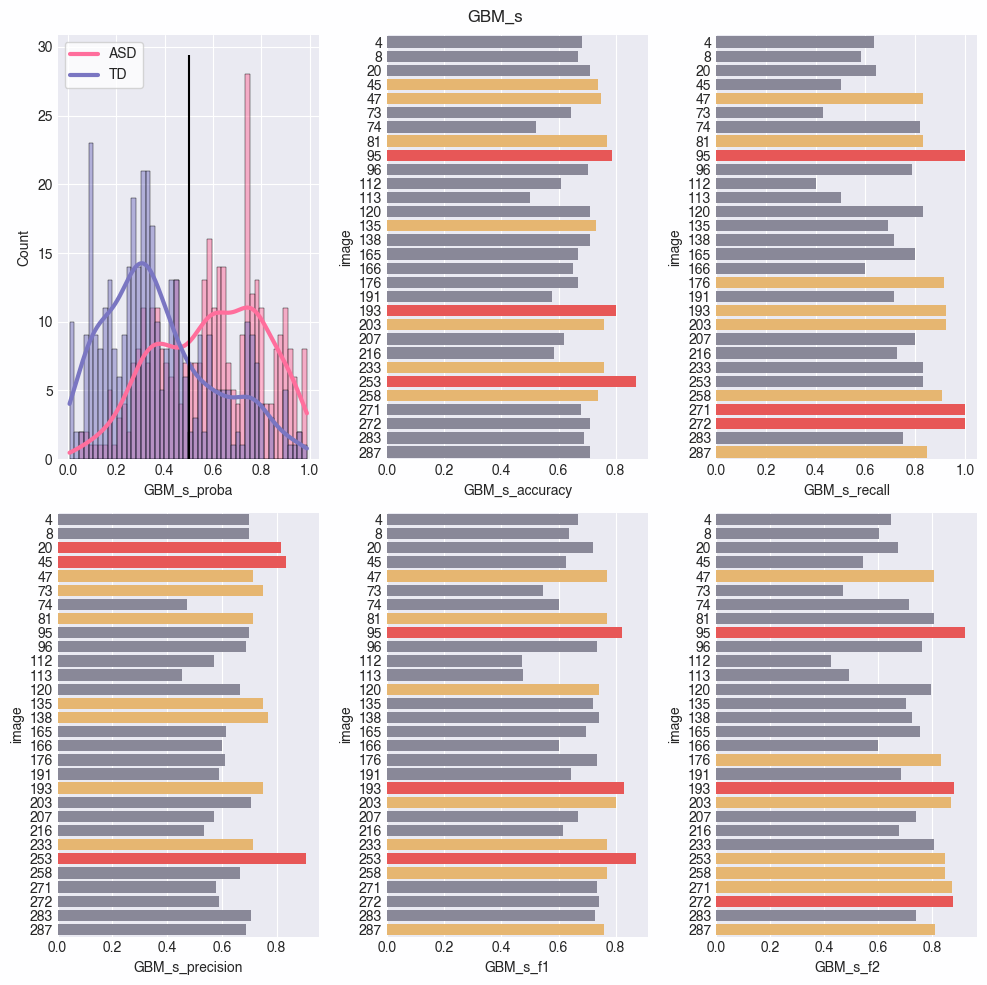

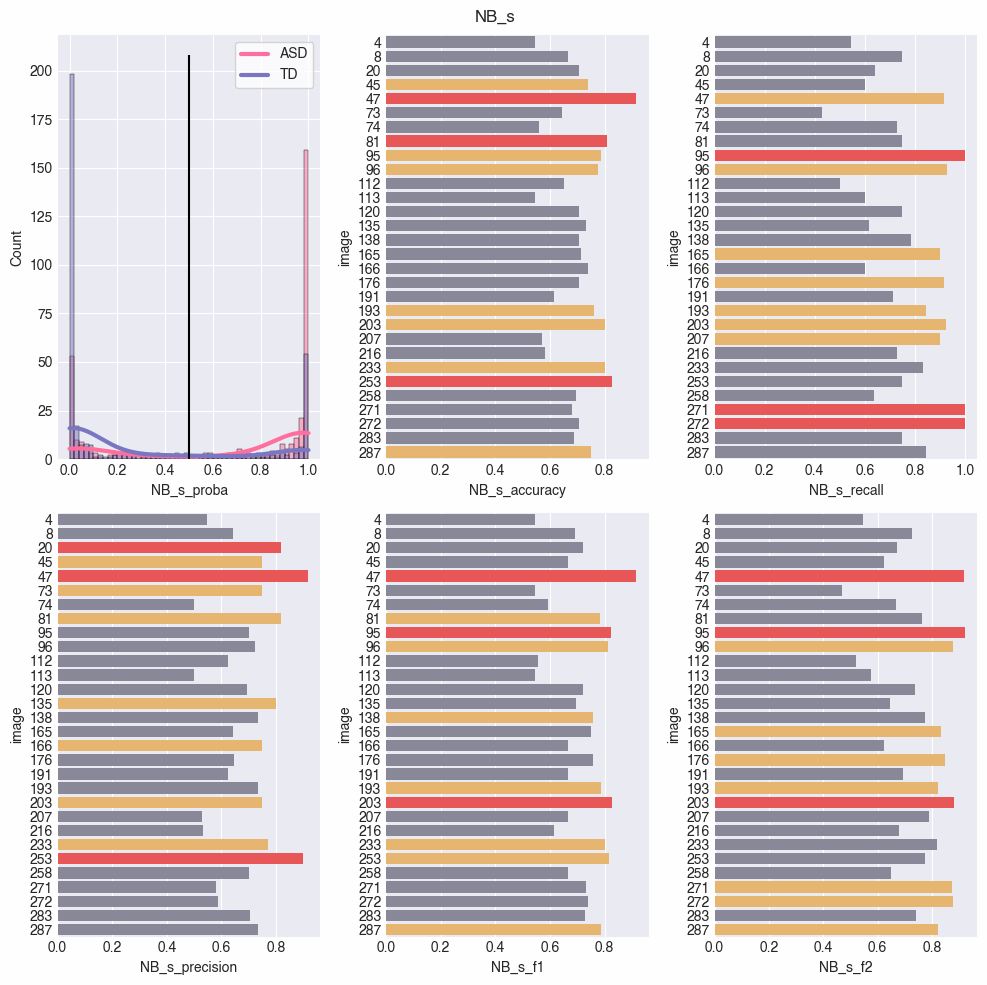

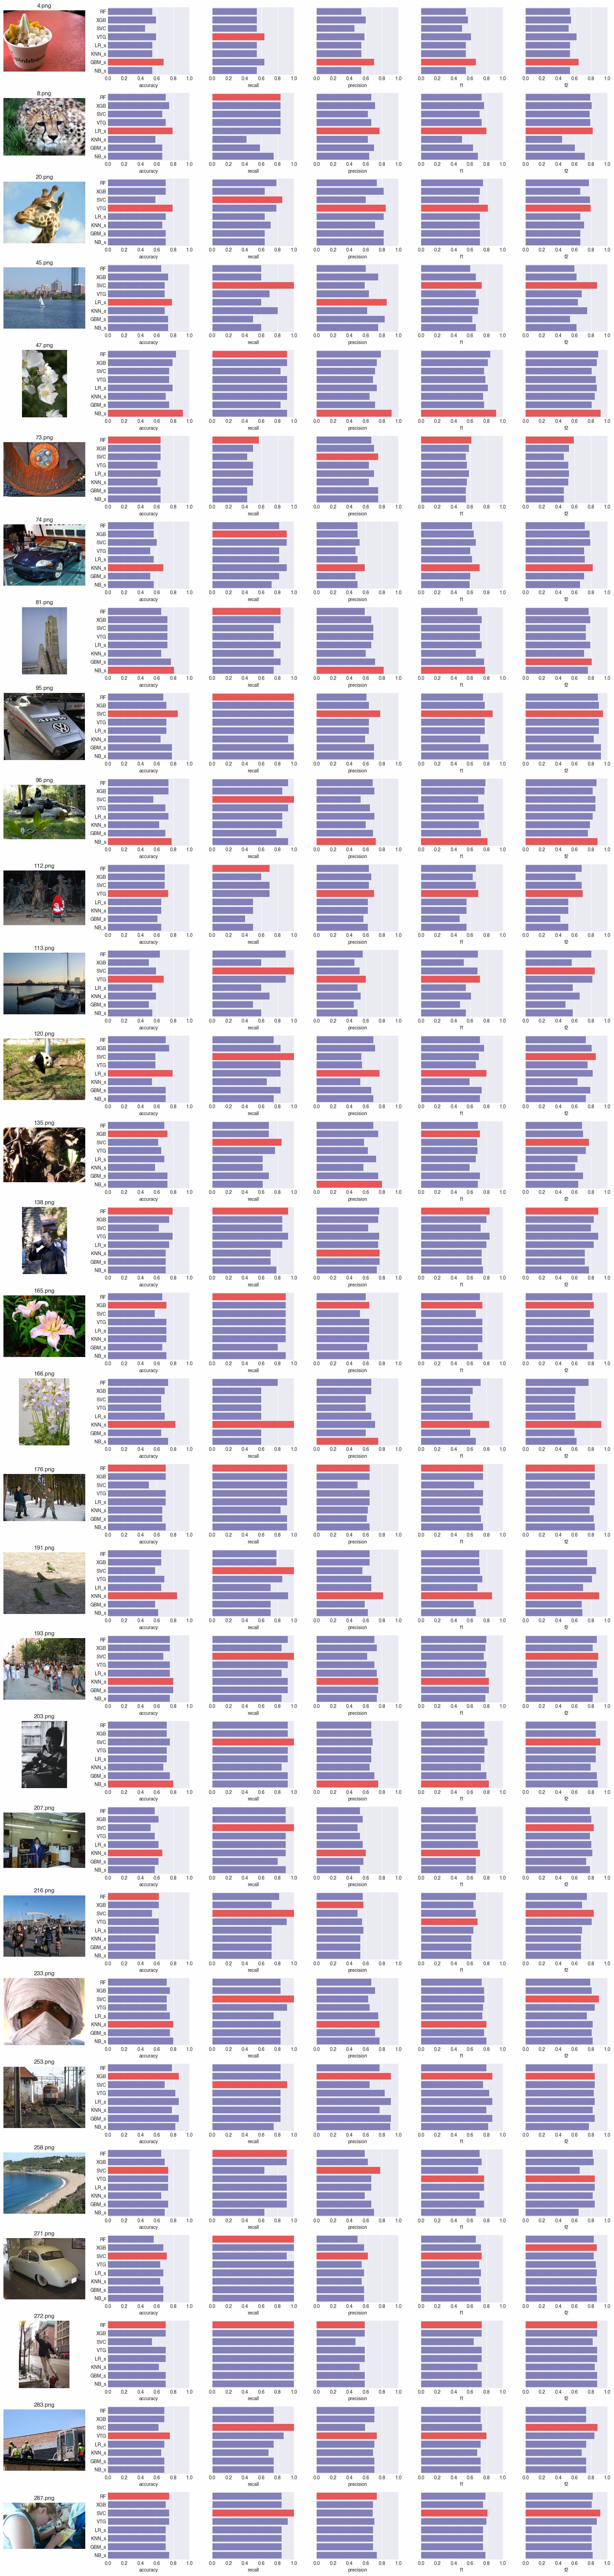

In [6]:
# Here we use the inp Dictionary in the Custom Function which Helps us on the Error Analysis
em.error_compare_models(inp, y_test)

# LADYS AND GENTLEMEN! FINAL DF AND SCORE

### Here we do some Feature Engineering to get the Data in Shape and Matched

In [7]:

# get the predicted classes per Model
predictions = {
    "RF": pred_rf,
    "XGB": pred_xgb,
    "SVC": pred_svc,
    "VTG": pred_vtg,
    "LR_s": pred_LR,
    "KNN_s": pred_KNN,
    "GBM_s": pred_GBM,
    "NB_s": pred_NB,
}

# Define a dictionary to map the substrings to the corresponding models and column names
substring_to_column = {
    '_047_': 'NB_s',
    '_095_': 'SVC',
    '_096_': 'NB_s',
    '_138_': 'RF',
    '_166_': 'KNN_s',
    '_191_': 'KNN_s',
    '_203_': 'SVC',
    '_253_': 'XGB',
    '_287_': 'SVC'
}

### Define some Functions we need to do this

In [8]:

# Custom Function for building the Final Dataframe for Evaluation
def build_pred_dataframe(y_test, predictions):
    # Create an empty DataFrame
    df = pd.DataFrame()

    # Add the Index as own column (not necessary but easier for further processing)

    df["sample_id"] = y_test.index 
    # Add y_test as a column to the DataFrame
    df['y_test'] = y_test.values

    # Add predictions as new columns with model names
    for model, pred in predictions.items():
        df[model] = pred

    return df

### Create new DF with Picture model_pred and which model made pred (to control)

In [9]:

def make_pred_df(y_test_full, substring_to_column):
    # Create an empty DataFrame to store the predictions
    pred_df = pd.DataFrame(columns=['sample_id', 'y_test', 'model_pred', 'model_name'])

    # Iterate over each substring and corresponding column
    for substring, column in substring_to_column.items():
        # Filter the DataFrame based on the presence of the substring in the "sample_id" column
        filtered_df = y_test_full[y_test_full['sample_id'].str.contains(substring)]
        # Extract the predicted values from the specified column
        pred_values = filtered_df[column].values
        # Create a temporary DataFrame to store the filtered data with model names
        temp_df = pd.DataFrame({'sample_id': filtered_df['sample_id'], 
                                'y_test': filtered_df['y_test'], 
                                'model_pred': pred_values,
                                'model_name': column})
        # Append the temporary DataFrame to the pred_df DataFrame
        pred_df = pd.concat([pred_df, temp_df], ignore_index=True)

    return pred_df


### Calling the Functions for Overview Dataframe

In [11]:
y_test_full = build_pred_dataframe(y_test,predictions)


final_df = make_pred_df(y_test_full, substring_to_column)


In [12]:
y_test_full.head()

sample_id  y_test  RF  XGB  SVC  VTG  LR_s  KNN_s  GBM_s  NB_s
0  asd_112_01       1   0    0    0    0     0      1      0     0
1  asd_112_02       1   1    1    1    1     0      0      0     0
2  asd_112_03       1   1    0    1    1     0      0      0     0
3  asd_112_04       1   1    1    1    1     1      1      1     1
4  asd_112_05       1   1    1    1    1     1      1      1     1

# Do this in TEAM MEETING PLS: Control if picture and model Match!!!

Get all these Column into 1 Column model_pred, each to it's corresponding Picture which was choosen

In [13]:
final_df.head()

sample_id y_test model_pred model_name
0  asd_047_00      1          1       NB_s
1  asd_047_01      1          1       NB_s
2  asd_047_03      1          1       NB_s
3  asd_047_05      1          1       NB_s
4  asd_047_07      1          1       NB_s

In [15]:
# Extract y_test, model_pred, and model_name from the DataFrame
y_true = final_df['y_test'].values.tolist()
y_pred = final_df['model_pred'].values.tolist()

# Final Model Evaluation on the Test Set

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.925     0.685     0.787       108
           1      0.764     0.948     0.846       116

    accuracy                          0.821       224
   macro avg      0.844     0.817     0.817       224
weighted avg      0.842     0.821     0.818       224

f(0.5)-score: 0.795
f(2.0)-score: 0.905



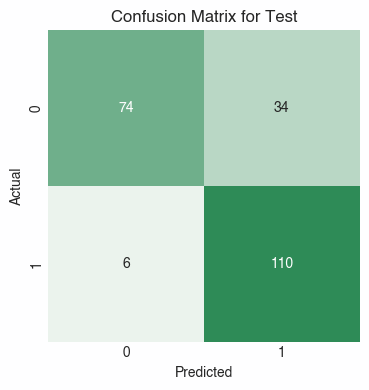

In [16]:
em.report(y_test=y_true, y_test_pred=y_pred)